# Perfect Classifier results analysis
This notebook can be used to visualise performance of the perfect classifier, after cross-validated classification was performed.

## Imports and required function definitions

In [62]:
import os

from joblib import Parallel, delayed
import qiime2
import biom
import numpy as np
import pandas as pd
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem

from glob import glob
import json

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline

In [72]:
def _calc_prf(exp_taxa, obs_taxa, table):
    # calculate weighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=table,
        sample_id=None)
    prf['method'] = 'weighted'
    prf_results = prf

    # calculate unweighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=None,
        sample_id=None)
    prf['method'] = 'unweighted'
    prf_results = pd.concat([prf_results, prf])
    
    return prf_results


def _collapse_frequency_table_to_relative_frequency(table, taxonomy, level=7):
    for level in range(level, 0, -1):
        # to cater for truncated classifications
        try:
            table_l7 = taxa.methods.collapse(table=table, level=level, taxonomy=taxonomy)
            break
        except ValueError:
            pass
    rel_freq = feature_table.methods.relative_frequency(table_l7.collapsed_table)
    obs_table = rel_freq.relative_frequency_table.view(pd.DataFrame)
    return obs_table


def _eval_comp_basic(exp, obs, depth=7):
    exp, obs = _match_samples_by_index(exp, obs)

    # DROP NANS/ZERO ABUNDANCE FEATURES
    obs = _drop_nans_zeros(obs)
    exp = _drop_nans_zeros(exp)

    for depth in range(depth, 0, -1):
        # TAR/TDR for obs vs. exp at each level
        try:
            results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth)
            break
        except ValueError:
            pass
    return results


def _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp):
    table_fp = os.path.join(frequencies_dir, fn)
    table = qiime2.Artifact.load(table_fp)
    rel_freq = feature_table.methods.relative_frequency(table)
    rel_freq.relative_frequency_table.save(rel_freq_fp)
    table = rel_freq.relative_frequency_table.view(biom.Table)
    return table


def _eval_for_class_weights(
    cw, type_dir, expected_dir, fns, frequencies_dir, relative_frequencies_dir):
    prf_results = pd.DataFrame()
    eval_results = pd.DataFrame()
    if cw == sample_type:
        return prf_results, eval_results

    cw_dir = os.path.join(type_dir, cw)
    # evaluate taxonomy
    for fn in fns:
        if fn in ['log', 'log_missed']:
            continue
        sample, _ = os.path.splitext(fn)

        # convert table to relative frequencies
        rel_freq_fp = os.path.join(relative_frequencies_dir, fn)
        if not os.path.exists(rel_freq_fp):
            table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)
        else:
            try:
                table = qiime2.Artifact.load(rel_freq_fp).view(biom.Table)
            except Exception as e:
                print(
                    f"An exception has occurred: {e}. Will try to recreate artifact."
                )
                table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)

        # load data
        exp_taxa_fp = os.path.join(expected_dir, fn)
        exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.DataFrame)
        obs_taxa_fp = os.path.join(cw_dir, fn)
        obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.DataFrame)

        results = _calc_prf(exp_taxa, obs_taxa, table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        prf_results = pd.concat([prf_results, results])

        # evaluate composition
        table_fp = os.path.join(frequencies_dir, fn)
        table = qiime2.Artifact.load(table_fp)
        exp_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(exp_taxa_fp))
        obs_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(obs_taxa_fp))

        results = _eval_comp_basic(exp_table, obs_table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        eval_results = pd.concat([eval_results, results])

    return prf_results, eval_results

def _check_sample_type(fns, df, class_weights, sample_type, is_prf=False):
    if len(df) == 0:
        return fns
    type_and_weight = df[df['sample type'] == sample_type]['sample']
    for_eval = []
    for fn in fns:
        levels = sum(type_and_weight == fn[:-4])
        m = 2 if is_prf else 1
        assert levels == 0 or levels == 7*m*(len(class_weights) - 1), \
            'got partial record for ' + fn
        if levels == 0:
            for_eval.append(fn)
    return for_eval

def _get_params_from_model(model_descriptor):
    # RandomForest/9-16-1000-sqrt-0.8
    # perfect-150-weighted-0.25        
    model_id, confidence, suffix, weights = None, None, None, None
    param_split = model_descriptor.split('-')
    model_id = param_split[0]
    confidence = float(param_split[-1])
    weights = param_split[-2]
    if len(param_split) == 4:
        suffix = param_split[1]
    return model_id, confidence, suffix, weights

def read_folds_info(folds_loc):
    test_seqs = {}
    for fold in glob(os.path.join(folds_loc, "*")):
        fold_base = fold.split("/")[-1]
        if fold_base.startswith("fold"):
            with open(os.path.join(fold, "sample_test.json")) as json_file:
                seq_ids = json.load(json_file)
                test_seqs[fold_base] = seq_ids
    test_seqs_map = {}
    for fold, seq_ids in test_seqs.items():
        for seq_id in seq_ids:
            if seq_id not in test_seqs_map.keys():
                test_seqs_map[seq_id] = fold.split("-")[-1]
            else:
                print(f"Sequence id {seq_id} already exists! - skipping")

    test_seqs_map_df = pd.DataFrame(test_seqs_map.items(), columns=["id", "fold"])
    return test_seqs_map_df

## Data sources and sample types
In order to run the analyses below, update the path to where your data is located (`project_dir`). Also, indicate which sample types you want to use in the analysis (corresponding directories need to exist within your project directory). Class weights paths will be discovered automatically - you should see them below.

Most of the analyses/figures presented here refer to only one sample type though, so only the first element of `sample_types` is usually taken into account.

In [3]:
project_dir = os.path.expandvars('/Users/mziemski/feature_classifier_paper/data/eval_perfect/')
sample_types = ['animal-distal-gut']

In [4]:
class_weights = []
for path in glob(os.path.join(project_dir, sample_types[0], 'results', 'PerfectClassifier', '*')):
    class_weights.append('/'.join(path.split('/')[-2:]))

In [5]:
class_weights

[]

## Run the evaluation

#### Evaluate cross-validation results or read the evaluation from file.

In [6]:
if os.path.exists(os.path.join(project_dir, 'eval_comp_results.tsv')):
    eval_comp_results = pd.read_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
else:
    eval_comp_results = pd.DataFrame()
if os.path.exists(os.path.join(project_dir, 'eval_taxa_prf.tsv')):
    prf_results = pd.read_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    prf_results = pd.DataFrame()

if not eval_comp_results.shape[0] > 0 and not prf_results.shape[0] > 0:
    for sample_type in sample_types:
        type_results = pd.DataFrame()
        type_dir = os.path.join(project_dir, sample_type, 'results')
        expected_dir = os.path.join(type_dir, 'expected')
        fns = os.listdir(expected_dir)
        frequencies_dir = os.path.join(type_dir, 'abundance')
        relative_frequencies_dir = os.path.join(type_dir, 'relative_frequencies')
        if not os.path.exists(relative_frequencies_dir):
            os.makedirs(relative_frequencies_dir)

        results = Parallel(n_jobs=6, verbose=50, batch_size=1)(
            delayed(_eval_for_class_weights)(
                cw, type_dir, expected_dir, fns, 
                frequencies_dir, relative_frequencies_dir) 
            for cw in class_weights)

        prf_list, eval_list = zip(*results)
        prf_results = pd.concat([prf_results] + list(prf_list))
        eval_comp_results = pd.concat([eval_comp_results] + list(eval_list))
        
        eval_comp_results.to_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
        prf_results.to_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    print("Evaluation results were loaded from a file.")

Evaluation results were loaded from a file.


In [7]:
print("Evaluation results shape:", eval_comp_results.shape, "and columns:", eval_comp_results.columns)
print("PRF results shape:", prf_results.shape)

Evaluation results shape: (788480, 17) and columns: Index(['Unnamed: 0', 'sample', 'level', 'Observed Taxa',
       'Observed / Expected Taxa', 'TAR', 'TDR', 'Slope', 'Intercept',
       'r-value', 'P value', 'Std Err', 'Bray-Curtis', 'Jaccard', 'r-squared',
       'class weights', 'sample type'],
      dtype='object')
PRF results shape: (1576960, 9)


In [8]:
prf_results["class weights"].unique()

array(['perfect-150-weighted-0.25', 'perfect-weighted-0.05',
       'perfect-weighted-0.5', 'perfect-weighted-0.95',
       'perfect-uniform-0.5', 'perfect-150-uniform-0.95',
       'perfect-150-uniform-0.25', 'perfect-uniform-0.95',
       'perfect-uniform-0.05', 'perfect-150-uniform-0.5',
       'perfect-150-weighted-0.95', 'perfect-150-uniform-0.75',
       'perfect-weighted-0.75', 'perfect-weighted-0.25',
       'perfect-uniform-0.75', 'perfect-150-weighted-0.05',
       'perfect-150-weighted-0.5', 'perfect-150-uniform-0.05',
       'perfect-150-weighted-0.75', 'perfect-uniform-0.25'], dtype=object)

In [9]:
# clean up some stray columns (all starting with "Unnamed" - probably DF index that was repeatedly saved to file)
cols_to_keep = [col for col in eval_comp_results.columns if not col.startswith('Unnamed')]
eval_comp_results_clean = eval_comp_results[cols_to_keep]

cols_to_keep = [col for col in prf_results.columns if not col.startswith('Unnamed')]
prf_results_clean = prf_results[cols_to_keep]
prf_results_clean["model name"], prf_results_clean["confidence"], prf_results_clean["suffix"], prf_results_clean["weights"] = zip(
    *prf_results_clean["class weights"].apply(_get_params_from_model))

# save as a backup
eval_comp_results_clean.to_csv(os.path.join(project_dir, 'eval_comp_results_cleaned.tsv'), sep='\t')
prf_results_clean.to_csv(os.path.join(project_dir, 'eval_taxa_prf_cleaned.tsv'), sep='\t')

print(eval_comp_results_clean.shape, prf_results_clean.shape)

(788480, 16) (1576960, 12)


In [10]:
prf_results_clean.tail(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,suffix,weights
1576958,6,0.916667,0.897490,0.906977,unweighted,perfect-uniform-0.25,animal-distal-gut,11113.301.36782,perfect,0.25,None,uniform
1576959,7,0.892779,0.853556,0.872727,unweighted,perfect-uniform-0.25,animal-distal-gut,11113.301.36782,perfect,0.25,None,uniform


#### Read in information about the cross-validation folds.

In [12]:
folds_loc = os.path.join(project_dir, sample_types[0], "tmp")
test_seqs_map_df = read_folds_info(folds_loc)
test_seqs_map_df.head(4)

,id,fold
0,11113.441.36784,2
1,894.OS615.lane3.NoIndex.L003.30696,2
2,894.SV1403.lane5.NoIndex.L005.30696,2
3,10422.12.F.13.35074,2


#### Read in information about abundance

In [59]:
abundance = pd.read_csv(os.path.join(project_dir, sample_types[0], "abundance.tsv"), sep='\t', index_col=0, header=None, squeeze=True, names=["sample", "abundance"]).astype(int, copy=False)
abundance.head(4)

sample
11113.393.36784                  10476
550.L1S248.s.1.sequence.30395     1200
10422.36.F.5.35074               34863
11113.441.36784                  10358
Name: abundance, dtype: int64

## Visualise classification accuracy 
Run the cells below to generate plots showing various accuracy metrics of different samples and class weights (your classifiers) at all taxonomy levels. Only results of `weighted` analysis will be taken into account and used for plotting. All plots will be generated only for the `species` level (level 7).

In [13]:
level7 = prf_results_clean[prf_results_clean['level'] == 7]
level7_weighted = level7[level7['method'] == 'weighted']

In [14]:
print(level7_weighted.shape)
level7_weighted.head(2)

(112640, 12)


,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,suffix,weights
6,7,0.894425,0.837458,0.865005,weighted,perfect-150-weighted-0.25,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.25,150,weighted
20,7,0.907105,0.889849,0.898394,weighted,perfect-150-weighted-0.25,animal-distal-gut,10323.B46G19.F.1011A.30841,perfect,0.25,150,weighted


Add information about folds.

In [15]:
level7_weighted_folds = pd.merge(left=level7_weighted, right=test_seqs_map_df, left_on="sample", right_on="id")

if level7_weighted_folds.shape[0] != level7_weighted.shape[0]:
    print("Some samples were lost during merging fold information into original df.")
else:
    print("Merge successful.")

print("Rows without fold info:", level7_weighted_folds[level7_weighted_folds["fold"].isnull()].shape[0])

Merge successful.
Rows without fold info: 0


Add information about abundance.

In [60]:
level7_weighted_folds_abundance = pd.merge(left=level7_weighted_folds, right=abundance, left_on="sample", right_index=True)

if level7_weighted_folds_abundance.shape[0] != level7_weighted_folds.shape[0]:
    print("Some samples were lost during merging abundance information into original df.")
else:
    print("Merge successful.")

print("Rows without abundance info:", level7_weighted_folds_abundance[level7_weighted_folds_abundance["abundance"].isnull()].shape[0])

Merge successful.
Rows without abundance info: 0


In [61]:
level7_weighted_folds_abundance.head()

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,suffix,weights,id,fold,abundance
0,7,0.894425,0.837458,0.865005,weighted,perfect-150-weighted-0.25,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.25,150,weighted,894.UY45.lane3.NoIndex.L003.30696,3,7395
1,7,0.930693,0.877079,0.903091,weighted,perfect-weighted-0.05,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.05,None,weighted,894.UY45.lane3.NoIndex.L003.30696,3,7395
2,7,0.931887,0.876944,0.903581,weighted,perfect-weighted-0.5,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.50,None,weighted,894.UY45.lane3.NoIndex.L003.30696,3,7395
3,7,0.995402,0.761190,0.862682,weighted,perfect-weighted-0.95,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.95,None,weighted,894.UY45.lane3.NoIndex.L003.30696,3,7395
4,7,0.969300,0.841109,0.900666,weighted,perfect-uniform-0.5,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,perfect,0.50,None,uniform,894.UY45.lane3.NoIndex.L003.30696,3,7395


### Read in NB, RF and CNN data

In [104]:
data_rf_path = "/Users/mziemski/feature_classifier_paper/data/eval_rf/eval_taxa_prf_cleaned.tsv"
data_cnn_path = "/Users/mziemski/feature_classifier_paper/data/eval_cnn/eval_taxa_prf_cleaned.tsv"
data_nb_path = "/Users/mziemski/feature_classifier_paper/data/eval_nb/eval_taxa_prf_cleaned.tsv"

data_rf = pd.read_csv(data_rf_path, sep='\t', index_col=0)
data_cnn = pd.read_csv(data_cnn_path, sep='\t', index_col=0)
data_nb = pd.read_csv(data_nb_path, sep='\t', index_col=0)

/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
data_rf = data_rf[data_rf["class weights"].str.contains("none-100-none")]
data_rf.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,max_depth,n_features,n_estimators
2829204,1,1.0,1.000000,1.000000,weighted,RandomForest/30-none-100-none-0.8,sediment-non-saline,10184.10030521.61428,RandomForest30,0.8,none,none,100.0
2829205,2,1.0,0.962141,0.980705,weighted,RandomForest/30-none-100-none-0.8,sediment-non-saline,10184.10030521.61428,RandomForest30,0.8,none,none,100.0


In [106]:
data_cnn = data_cnn[data_cnn["class weights"].str.contains("Ben9|nb")]
data_cnn.head(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,model suffix
1261568,1,1.000000,1.000000,1.000000,weighted,nb,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,nb,0.7,none
1261569,2,0.999865,0.999189,0.999527,weighted,nb,animal-distal-gut,894.UY45.lane3.NoIndex.L003.30696,nb,0.7,none


### Metrics per taxonomic level

Generate one horizontal plot with selected models.

In [88]:
from matplotlib.ticker import AutoMinorLocator

def plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=None):
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(24, 5)

        # calculate mean metric for each fold by grouping by model
        # reset index to unstack all the levels from the multi-level index for easy plotting
        grouped_level7 = data.groupby(['model name', 'level', 'confidence', 'fold', "class weights"] + params)
        axis_data = grouped_level7.apply(weighted_stats, **{"metric": metric}).reset_index()
        axis_data.sort_values(["confidence"] + params, ascending=True, inplace=True)
        
        print(axis_data.head())
        
        # sort by confidence to plot in confidence groups
        all_models = axis_data["class weights"].unique()
        all_models_sorted = sorted(all_models, key=lambda x: x.rsplit("-", 1)[0])

        # set proper colours
        base_colors = sns.color_palette(palette, axis_data[params].drop_duplicates(inplace=False).shape[0])
        color_palette = base_colors
        g = sns.boxplot(x="class weights", y=metric, data=axis_data, ax=axes, palette=color_palette, order=all_models_sorted)

        # set custom y ticks
        g.yaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
        if y_ticks_minor > 1:
            minor_locator = AutoMinorLocator(y_ticks_minor)
            g.yaxis.set_minor_locator(minor_locator)
            g.tick_params(which='minor', length=4)
            g.grid(True, which='minor', axis='y')

        # set some font sizes
        g.yaxis.label.set_size(15)
        for tick in g.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in g.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
            tick.label.set_rotation(90)

        # relabel x-axis tick for easier identification
        new_x_tick_labels = ["-".join(tick._text.split("/")[-1].split("-")[1:]) for tick in g.get_xticklabels()]
        g.set_xticklabels(new_x_tick_labels)

        if save_loc:
            fig.savefig(save_loc, dpi=300)
            
        plt.show()
        
        return axis_data

def calculate_aggregate_metrics(axis_data, metric, grouping_column):
    axis_data_grouped = axis_data[[metric, grouping_column]].groupby(grouping_column)
    metric_table = pd.concat([axis_data_grouped.mean(), axis_data_grouped.sem(), axis_data_grouped.count()], axis=1)
    metric_table.columns = [f"Avg {metric}", "SEM", "Count"]
    return metric_table

def weighted_stats(x, metric):
    d1 = DescrStatsW(x[metric], weights=x['abundance'])
    return pd.Series([d1.mean], index=[metric])

   model name  level  confidence fold              class weights  F-measure
0     perfect      7        0.05    0   perfect-150-uniform-0.05   0.878922
19    perfect      7        0.05    4      perfect-weighted-0.05   0.936828
18    perfect      7        0.05    4       perfect-uniform-0.05   0.904296
17    perfect      7        0.05    4  perfect-150-weighted-0.05   0.893139
16    perfect      7        0.05    4   perfect-150-uniform-0.05   0.863219


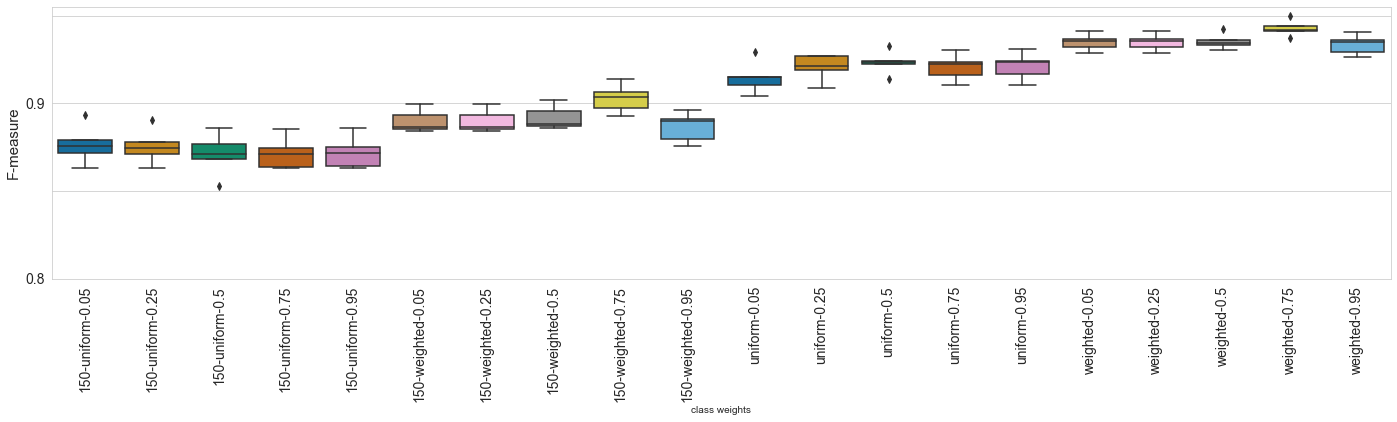

,Avg F-measure,SEM,Count
class weights,,,
perfect-150-uniform-0.05,0.876527,0.004973,5
perfect-150-uniform-0.25,0.875621,0.004474,5
perfect-150-uniform-0.5,0.871020,0.005407,5
perfect-150-uniform-0.75,0.871628,0.004059,5
perfect-150-uniform-0.95,0.872101,0.004057,5
perfect-150-weighted-0.05,0.889761,0.002881,5
perfect-150-weighted-0.25,0.889761,0.002881,5
perfect-150-weighted-0.5,0.891829,0.003007,5
perfect-150-weighted-0.75,0.902820,0.003556,5


In [90]:
metric = "F-measure"
params = []
y_ticks_major = [0.80, 1.0]
y_ticks_minor = 2
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights", "abundance"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
# save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")
save_loc = None

data_slice = level7_weighted_folds_abundance[["F-measure", "Precision", "Recall"] + params + other_columns]

selection1 = (data_slice["weights"].isin(["weighted", "uniform"]))
data = data_slice[selection1]

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

In [82]:
axis_data

,model name,level,confidence,fold,class weights,F-measure
0,perfect,7,0.05,0,perfect-150-uniform-0.05,0.878922
19,perfect,7,0.05,4,perfect-weighted-0.05,0.936828
18,perfect,7,0.05,4,perfect-uniform-0.05,0.904296
17,perfect,7,0.05,4,perfect-150-weighted-0.05,0.893139
16,perfect,7,0.05,4,perfect-150-uniform-0.05,0.863219
...,...,...,...,...,...,...
81,perfect,7,0.95,0,perfect-150-weighted-0.95,0.890013
80,perfect,7,0.95,0,perfect-150-uniform-0.95,0.874911
98,perfect,7,0.95,4,perfect-uniform-0.95,0.910641
88,perfect,7,0.95,2,perfect-150-uniform-0.95,0.885893


   model name  level  confidence fold              class weights  Precision
0     perfect      7        0.05    0   perfect-150-uniform-0.05   0.882202
19    perfect      7        0.05    4      perfect-weighted-0.05   0.941674
18    perfect      7        0.05    4       perfect-uniform-0.05   0.907443
17    perfect      7        0.05    4  perfect-150-weighted-0.05   0.899324
16    perfect      7        0.05    4   perfect-150-uniform-0.05   0.866886


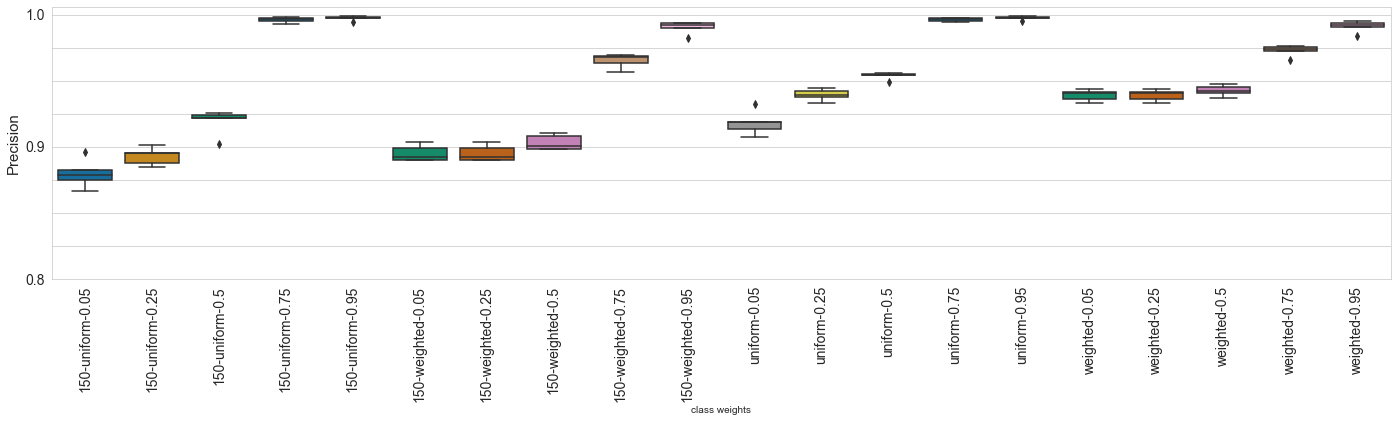

,Avg Precision,SEM,Count
class weights,,,
perfect-150-uniform-0.05,0.879635,0.004749,5
perfect-150-uniform-0.25,0.892726,0.002902,5
perfect-150-uniform-0.5,0.919075,0.004328,5
perfect-150-uniform-0.75,0.995877,0.000868,5
perfect-150-uniform-0.95,0.997315,0.000712,5
perfect-150-weighted-0.05,0.895083,0.002706,5
perfect-150-weighted-0.25,0.895083,0.002706,5
perfect-150-weighted-0.5,0.903205,0.002643,5
perfect-150-weighted-0.75,0.965245,0.002373,5


In [83]:
metric = "Precision"
params = []
y_ticks_major = [0.8, 1.01]
y_ticks_minor = 4
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

   model name  level  confidence fold              class weights    Recall
0     perfect      7        0.05    0   perfect-150-uniform-0.05  0.875867
19    perfect      7        0.05    4      perfect-weighted-0.05  0.932588
18    perfect      7        0.05    4       perfect-uniform-0.05  0.901402
17    perfect      7        0.05    4  perfect-150-weighted-0.05  0.887894
16    perfect      7        0.05    4   perfect-150-uniform-0.05  0.859826


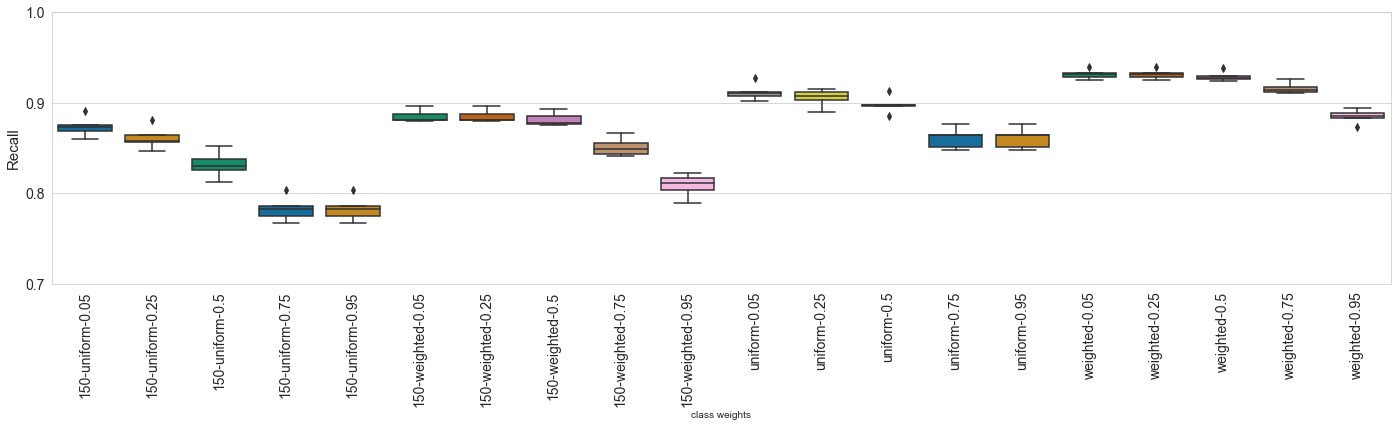

,Avg Recall,SEM,Count
class weights,,,
perfect-150-uniform-0.05,0.873647,0.005165,5
perfect-150-uniform-0.25,0.861033,0.005627,5
perfect-150-uniform-0.5,0.831705,0.006473,5
perfect-150-uniform-0.75,0.783067,0.006142,5
perfect-150-uniform-0.95,0.782998,0.006154,5
perfect-150-weighted-0.05,0.885075,0.003059,5
perfect-150-weighted-0.25,0.885074,0.003058,5
perfect-150-weighted-0.5,0.881615,0.003379,5
perfect-150-weighted-0.75,0.851116,0.004646,5


In [87]:
metric = "Recall"
params = []
y_ticks_major = [0.7, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights"]
conf_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-allmodels-updated-low-confs.svg")

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")